In [1]:
import cv2
import os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
data_path = '/kaggle/input/koa-1500/MedicalExpert-I'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

img_size = 256
data = []
label = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

In [3]:
data = np.array(data) / 255.0
data_rgb = np.repeat(data[..., np.newaxis], 3, -1)
label = np.array(label)
new_label = np_utils.to_categorical(label)

x_train, x_test, y_train, y_test = train_test_split(data_rgb, new_label, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(x_train)

In [4]:
model = Sequential()
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers[:5]:
    layer.trainable = False

model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

In [5]:
checkpoint = ModelCheckpoint('/kaggle/working/model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
callbacks = [checkpoint]

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=80,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks)

Epoch 1/80
37/37 [==============================] - ETA: 0s - loss: 1.6477 - accuracy: 0.2597
Epoch 1: val_accuracy improved from -inf to 0.27273, saving model to /kaggle/working/model.h5
37/37 [==============================] - 45s 710ms/step - loss: 1.6477 - accuracy: 0.2597 - val_loss: 1.5680 - val_accuracy: 0.2727
Epoch 2/80
37/37 [==============================] - ETA: 0s - loss: 1.5628 - accuracy: 0.3065
Epoch 2: val_accuracy did not improve from 0.27273
37/37 [==============================] - 21s 557ms/step - loss: 1.5628 - accuracy: 0.3065 - val_loss: 1.5584 - val_accuracy: 0.2727
Epoch 3/80
37/37 [==============================] - ETA: 0s - loss: 1.5596 - accuracy: 0.2840
Epoch 3: val_accuracy did not improve from 0.27273
37/37 [==============================] - 21s 555ms/step - loss: 1.5596 - accuracy: 0.2840 - val_loss: 1.5544 - val_accuracy: 0.2727
Epoch 4/80
37/37 [==============================] - ETA: 0s - loss: 1.5371 - accuracy: 0.3134
Epoch 4: val_accuracy did not im

In [6]:
model.load_weights('/kaggle/working/model.h5')

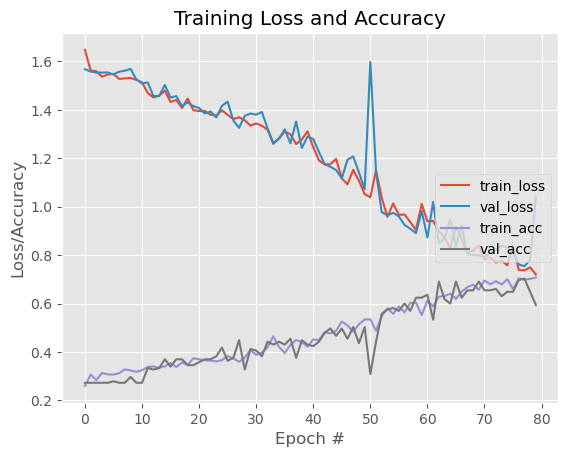

In [7]:
# Plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history.history["loss"])), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(history.history["val_loss"])), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(history.history["accuracy"])), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(history.history["val_accuracy"])), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("vgg_Model")

Test loss: 0.8367896676063538
Test accuracy: 0.678787887096405
1/1 [==============================] - 1s 682ms/step
A.I predicts: 4Severe
Correct prediction for label 1 is 3Moderate


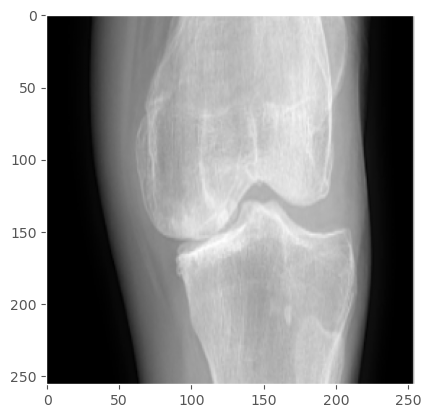

11/11 [==============================] - 1s 140ms/step


<Figure size 640x480 with 0 Axes>

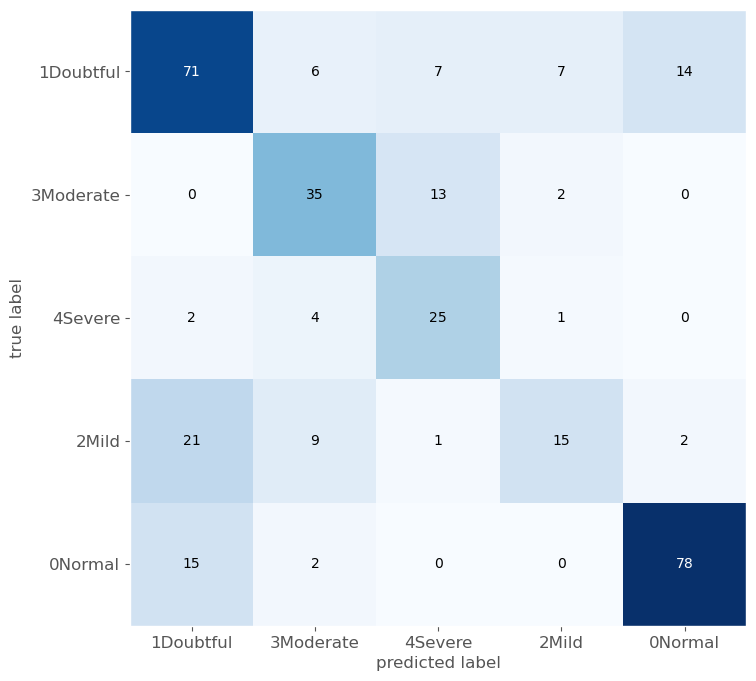

In [8]:
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

X = 32
img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = np.expand_dims(img_single, 0)

predictions_single = model.predict(img_single)
print('A.I predicts:', categories[np.argmax(predictions_single)])
print("Correct prediction for label", np.argmax(y_test[X]), 'is', categories[np.argmax(y_test[X])])
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()

test_labels = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)

cm = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm, figsize=(12, 8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=12)
plt.yticks(range(len(categories)), categories, fontsize=12)
plt.show()
